# New Data Sources
In this notebook we are going to look into adding new data to your dataset.
We start out with a taxi dataset describing all pickup points from taxis in a specific date interval, notice that the dataset is divided up into months. Each month has their specific csv file saved in an AWS location.




In [1]:
import pandas as pd
import seaborn as sns
sns.set_style()
sns.set(rc={'figure.figsize':(16,12)})

In [2]:
taxi_df = sns.load_dataset('taxis')
taxi_df.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


We would like to find out how many taxi rides were performed each day so we:
- parse the date string to a datetime format
- set the date as index
- resample to '1D' or one day (and chose count as aggregation)

In [3]:
taxi_df.pickup = pd.to_datetime(taxi_df.pickup)
taxi_df = taxi_df.set_index('pickup')

In [4]:
taxi_sum_df = taxi_df.resample('D').sum()
taxi_sum_df.head()

,passengers,distance,fare,tip,tolls,total
pickup,,,,,,
2019-02-28,1,0.90,5.00,0.00,0.00,6.30
2019-03-01,370,640.29,2946.97,442.47,60.34,4213.83
2019-03-02,310,548.70,2358.00,333.97,28.80,3319.02
2019-03-03,264,554.04,2187.89,307.47,34.56,3027.32
2019-03-04,267,583.81,2335.74,334.98,63.36,3269.08


great! now we have an idea on how many ubers were taken each day, let us use a simple line plot to show the results.

<AxesSubplot:xlabel='pickup', ylabel='passengers'>

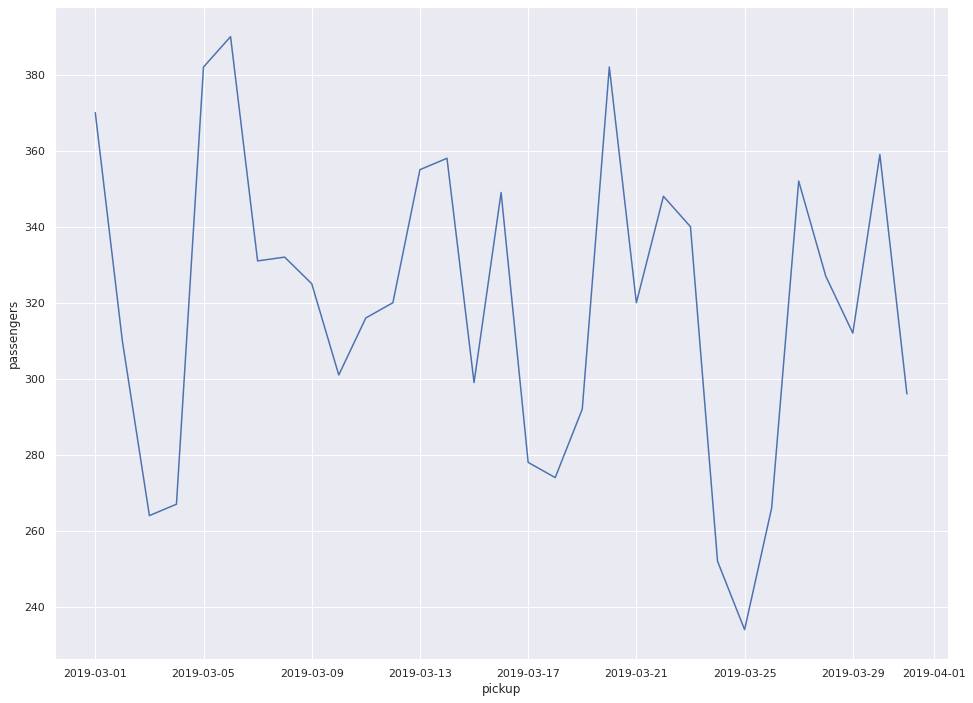

In [5]:
sns.lineplot(data=taxi_sum_df.passengers[1:])

This dataset is nice, but we want to know which factors might influence the taxi habits of NYC.
What we could do is add weather information to it.

We found a dataset online of the wether in and around central park, which should be relevant to NYC.

In [6]:
weather_df = pd.read_csv('https://raw.githubusercontent.com/toddwschneider/nyc-taxi-data/master/data/central_park_weather.csv')
weather_df.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-01,11.18,0.0,0.0,0.0,26,15
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-02,6.26,0.0,0.0,0.0,34,23
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-03,10.07,0.0,0.0,0.0,38,29
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-04,7.61,0.0,0.0,0.0,42,25
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2009-01-05,6.93,0.0,0.0,0.0,43,38


you can see a variaty of information, more info on the column names can be found [here](https://docs.opendata.aws/noaa-ghcn-pds/readme.html)  
again we need to:
- parse the date
- set it to the index and drop useless columns
- resampling is not needed as it is already in day-to-day intervals


In [7]:
weather_df.DATE =  pd.to_datetime(weather_df.DATE)
weather_df = weather_df.set_index('DATE').drop(columns=['STATION', 'NAME'])
weather_df.head()

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
DATE,,,,,,
2009-01-01,11.18,0.0,0.0,0.0,26,15
2009-01-02,6.26,0.0,0.0,0.0,34,23
2009-01-03,10.07,0.0,0.0,0.0,38,29
2009-01-04,7.61,0.0,0.0,0.0,42,25
2009-01-05,6.93,0.0,0.0,0.0,43,38


Having 2 dataset, now we need to merge them. Since we already prepared the date as index, this should be easy.

In [8]:
merged_df = pd.merge(taxi_sum_df, weather_df, left_index=True, right_index=True, how='left')
merged_df.head()

,passengers,distance,fare,tip,tolls,total,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
pickup,,,,,,,,,,,,
2019-02-28,1,0.90,5.00,0.00,0.00,6.30,NaN,0.03,0.1,0.0,37,27
2019-03-01,370,640.29,2946.97,442.47,60.34,4213.83,NaN,0.11,1.4,1.2,35,26
2019-03-02,310,548.70,2358.00,333.97,28.80,3319.02,NaN,0.53,4.0,3.9,41,31
2019-03-03,264,554.04,2187.89,307.47,34.56,3027.32,NaN,0.52,3.0,1.2,42,33
2019-03-04,267,583.81,2335.74,334.98,63.36,3269.08,NaN,0.29,2.0,3.9,38,28


In [9]:
merged_df.head()

,passengers,distance,fare,tip,tolls,total,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
pickup,,,,,,,,,,,,
2019-02-28,1,0.90,5.00,0.00,0.00,6.30,NaN,0.03,0.1,0.0,37,27
2019-03-01,370,640.29,2946.97,442.47,60.34,4213.83,NaN,0.11,1.4,1.2,35,26
2019-03-02,310,548.70,2358.00,333.97,28.80,3319.02,NaN,0.53,4.0,3.9,41,31
2019-03-03,264,554.04,2187.89,307.47,34.56,3027.32,NaN,0.52,3.0,1.2,42,33
2019-03-04,267,583.81,2335.74,334.98,63.36,3269.08,NaN,0.29,2.0,3.9,38,28


One would assume that when it is a rainy day, people would use more cabs. so let us seperate based on precipitation.

In [10]:
rained = merged_df[merged_df['PRCP']>0]
no_rain = merged_df[merged_df['PRCP']==0]

In [11]:
print('average passengers on a rainy day')
print(rained['passengers'].mean())
print('average passengers on a dry day')
print(no_rain['passengers'].mean())

average passengers on a rainy day
277.6
average passengers on a dry day
323.90909090909093


In [12]:
no_rain.shape

(22, 12)

ouch! it looks like the average new yorker doesn't mind getting wet, or they take a cab any day...  
using a regression plot we can see it more clear

<AxesSubplot:xlabel='PRCP', ylabel='passengers'>

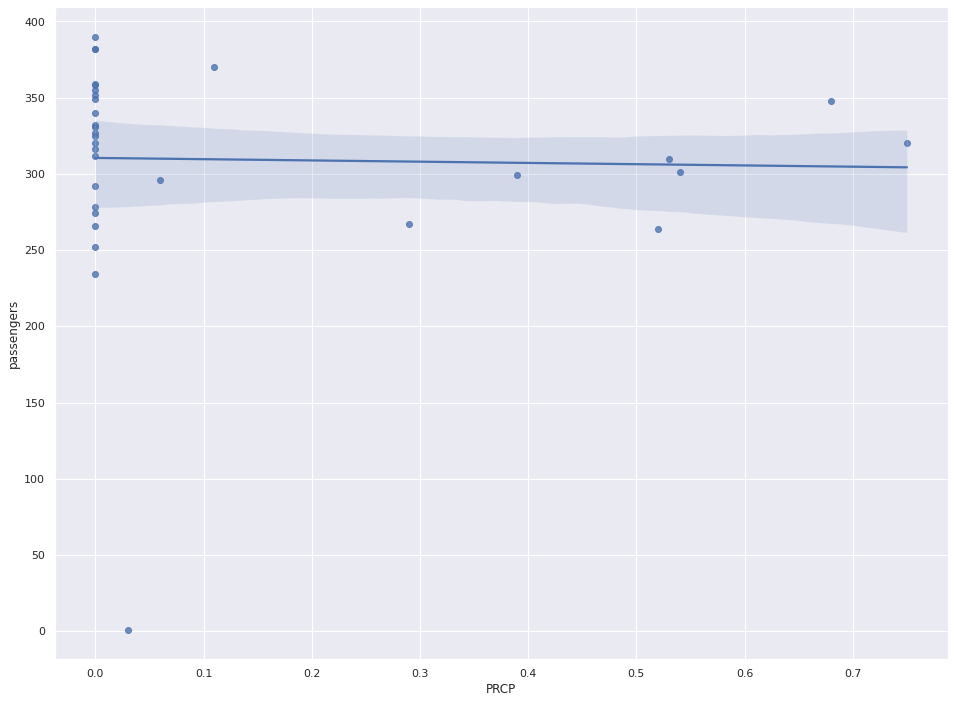

In [13]:
sns.regplot(data=merged_df, x='PRCP', y='passengers')

Ok, here we see that it might just be because a lot of days are dry and the dataset is skewed. Not reliable info.  
What about temperatures, can we see a difference if the lowest temperature changes?

<AxesSubplot:xlabel='SNWD', ylabel='passengers'>

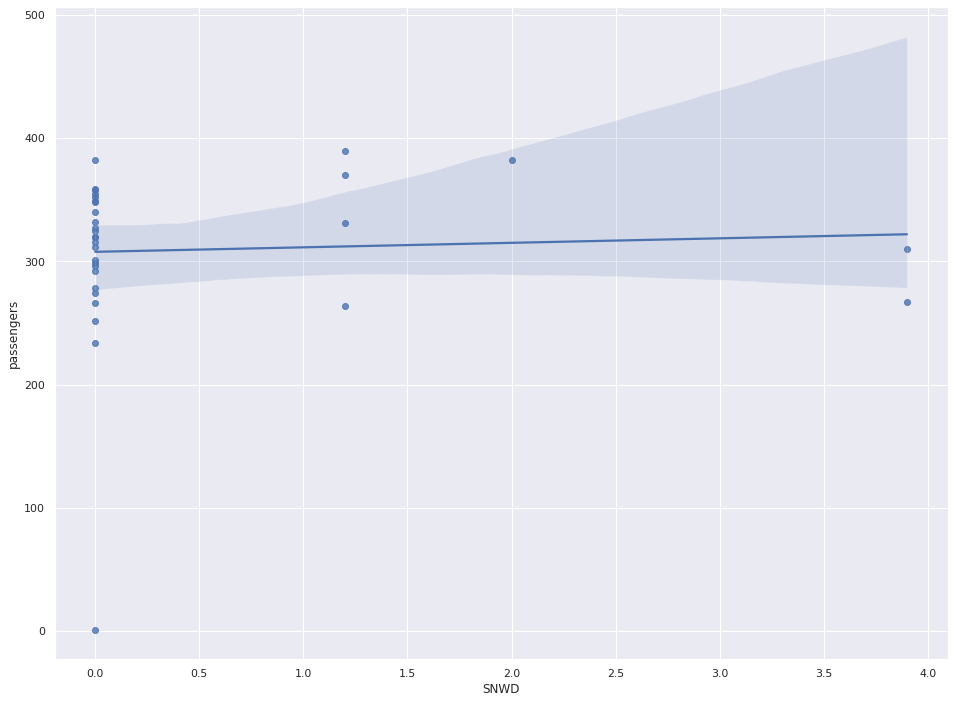

In [14]:
sns.regplot(data=merged_df, x='SNWD', y='passengers')

Appearantly when the temperature lowers, yorkers seem to be taking more cab rides. So global warming might be disastrous for capitalism after all?